In [1]:
! git clone https://github.com/wangjinzhulala/China_built_up.git

Cloning into 'China_built_up'...
remote: Enumerating objects: 1702, done.
remote: Counting objects: 100% (615/615), done.
remote: Compressing objects: 100% (480/480), done.
remote: Total 1702 (delta 259), reused 468 (delta 132), pack-reused 1087
Receiving objects: 100% (1702/1702), 208.96 MiB | 22.46 MiB/s, done.
Resolving deltas: 100% (823/823), done.
Checking out files: 100% (934/934), done.


In [2]:
% cd /content/China_built_up/Process_3_Temporal_Check

/content/China_built_up/Process_3_Temporal_Check


In [3]:
import ee
import datetime
import os
import itertools
import sys

from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# import geemap

import subprocess
from subprocess import PIPE

In [ ]:
! earthengine authenticate
ee.Initialize()

##### Basic parameters

In [27]:
# get research region
region = ee.FeatureCollection("users/wangjinzhulala/China_built_up/01_Boundary_shp/chengdu_chongqing")
region_name = 'chengdu_chongqing'

In [6]:
# define basic parameters
year_range = [f'{i}_{i+2}' for i in range(1990,2020,3)]

In [45]:
# get classifications
img_path = ! earthengine ls users/wangjinzhulala/China_built_up/06_temporal_corrected_classification
img_path = [i for i in img_path if "classification" in i]
img = ee.ImageCollection(img_path).mosaic()

In [8]:
# get sample points
pt_path = ! earthengine ls users/wangjinzhulala/China_built_up/04_sample_train_test_split
pt_path = [i for i in pt_path if "Grid" in i]


##### Calculate the acuracy after temporal correction

In [48]:
Acc_temporal_checked = {}

for i,year in enumerate(year_range):

        # get the img and untouched sample
        sample = [i for i in pt_path if 'Grid' in i]
        sample = [ee.FeatureCollection(i) for i in sample if year in i]
        sample = ee.FeatureCollection(sample).flatten().filterBounds(region)
        

        # get the classificaiton, rename the band so we can use Accuracy_assesment module
        img_my   = img.gte(len(year_range)-i).rename('classification')
        

        # extract the img pixel value to test_sample
        test_extract_img   = img_my.sampleRegions(  collection = sample, 
                                properties = ['Built'], 
                                scale      = 30,
                                tileScale  = 2)

        # compute the accuracy and put them into a df
        Acc = test_extract_img.errorMatrix('Built','classification').accuracy().getInfo()
        Acc_temporal_checked[year] = [Acc*100]
        
        
        # print out the process
        print(f'The overall acc of {year} is {Acc*100:.2f}')

The overall acc of 1990_1992 is 95.28
The overall acc of 1993_1995 is 94.78
The overall acc of 1996_1998 is 97.64
The overall acc of 1999_2001 is 96.45
The overall acc of 2002_2004 is 95.49
The overall acc of 2005_2007 is 97.71
The overall acc of 2008_2010 is 96.09
The overall acc of 2011_2013 is 98.41
The overall acc of 2014_2016 is 94.16
The overall acc of 2017_2019 is 97.10


In [24]:
Acc_temporal_checked_df = pd.DataFrame(Acc_temporal_checked).T
Acc_temporal_checked_df.reset_index(inplace=True)

In [25]:
Acc_temporal_checked_df

,index,0
0,1990_1992,95.275591
1,1993_1995,94.776119
2,1996_1998,97.637795
3,1999_2001,96.453901
4,2002_2004,95.488722
5,2005_2007,97.709924
6,2008_2010,96.093750
7,2011_2013,98.412698
8,2014_2016,94.160584
9,2017_2019,97.101449


In [29]:
# format the Acc_temporal_checked_df
Acc_temporal_checked_df = pd.DataFrame(Acc_temporal_checked).T
Acc_temporal_checked_df.reset_index(inplace=True)
Acc_temporal_checked_df.columns = ['Year','Accuracy']

# save the df to local drive
Acc_temporal_checked_df.to_csv(f'./Result/Temporal_check_acc_{region_name}.csv',index=False)

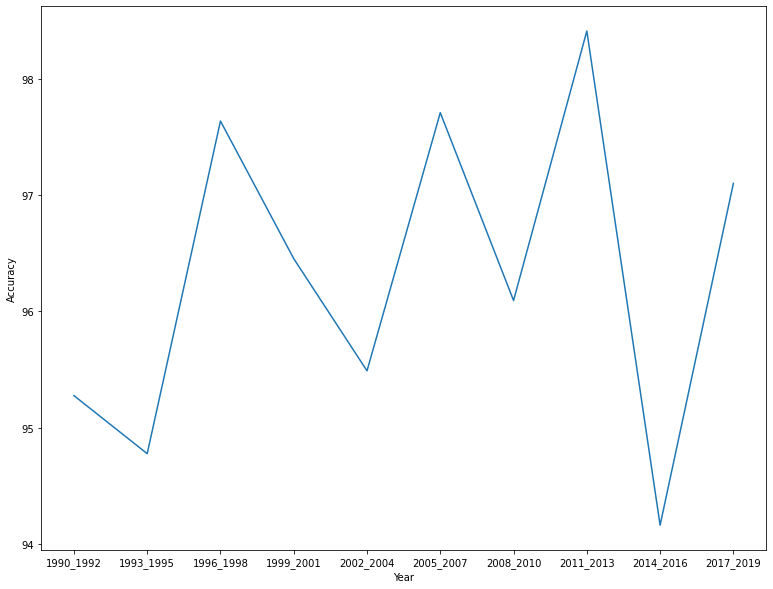

In [51]:
plt.figure(figsize=(13,10))
sns.lineplot(x='Year',y='Accuracy',data=Acc_temporal_checked_df)